In [1]:
import pandas as pd
from glob import glob
import math
import numpy as np
from skimage import io, morphology, img_as_ubyte, img_as_float, filters
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
from scipy import io as sio
from centerline import CenterLine, smooth_mask, iou
import colorsys

### Create centerlines from masks

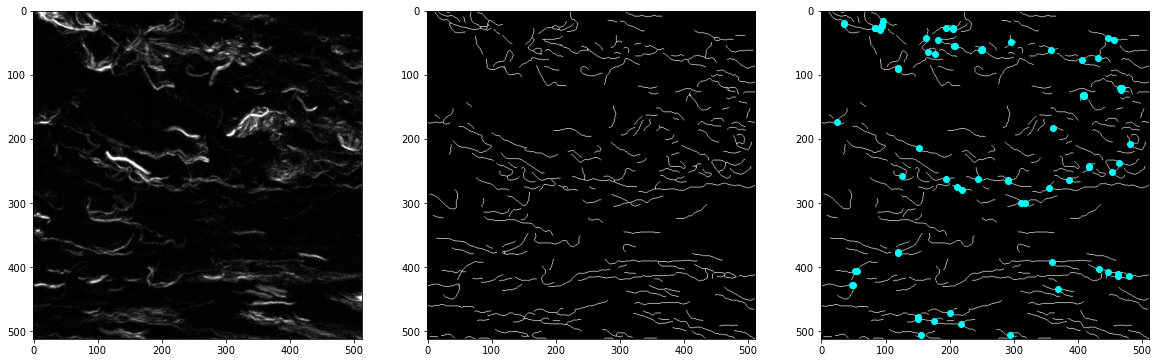

In [2]:
centerline = CenterLine(centerline_image=io.imread("examples/example_centerline.png"), associate_image=io.imread("examples/example_image.tif")) #
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

### Create centerline from dataframe (such as from output of ridge detetion plugin in FIJI)

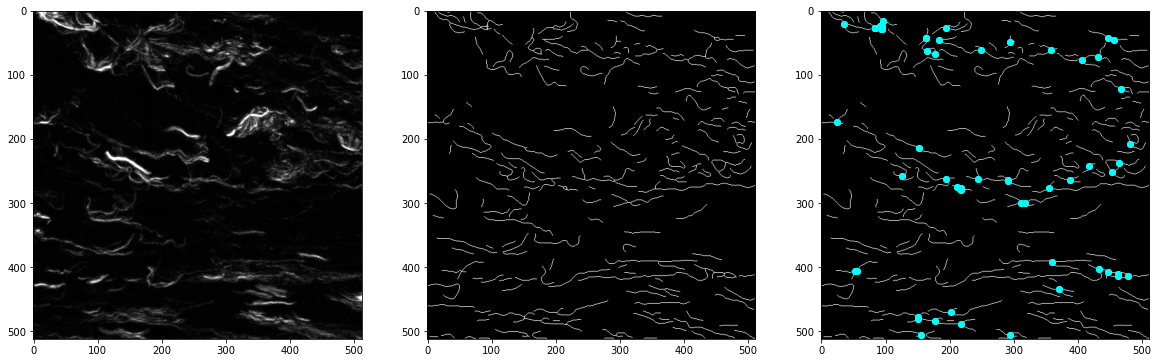

In [4]:
centerline = CenterLine(dataframe=pd.read_csv("examples/example_annotations.csv", index_col=0), associate_image=io.imread("examples/example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

### Create centerline from line_dict object

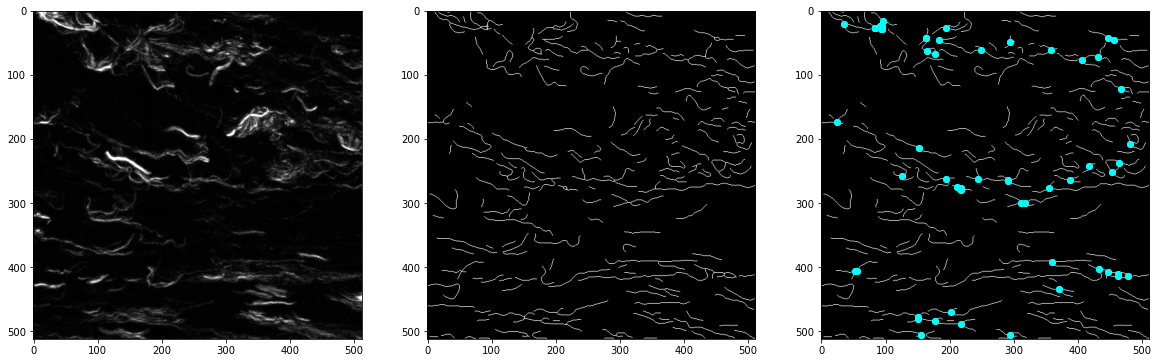

In [5]:
line_dict = centerline.line_dict
centerline = CenterLine(line_dict=line_dict, associate_image=io.imread("examples/example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

### Compute centerline features using centerline_image

In [6]:
centerline = CenterLine(centerline_image=io.imread("examples/example_centerline.png"), associate_image=io.imread("examples/example_image.tif"))
centerline.compute_fiber_feats() 
print(dict(list(centerline.feats.items())[:-1]))

{'cir_mean': -0.04554560616608039, 'cir_var': 0.45334978046000474, 'len_mean': 34.84375, 'len_var': 28.677978987275985, 'waviness': 0.3607832149304257, 'intensity': 7891}


### Compute centerline features using dataframe

In [7]:
centerline = CenterLine(dataframe=pd.read_csv("examples/example_annotations.csv", index_col=0), associate_image=io.imread("examples/example_image.tif"))
centerline.compute_fiber_feats() 
print(dict(list(centerline.feats.items())[:-1]))

{'cir_mean': -0.08156153750403283, 'cir_var': 0.46148936541982966, 'len_mean': 36.68544600938967, 'len_var': 30.02142622049813, 'waviness': 0.36283383034386185, 'intensity': 7779}


### Measure the similarity of two centerline (masks)

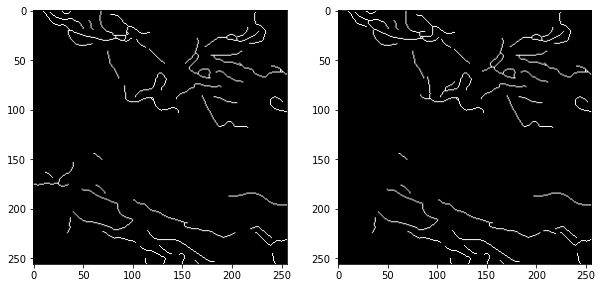

In [8]:
### any two centerline masks
image_1 = io.imread('examples/Annotation_Michael.tif')
image_2 = io.imread('examples/Annotation_Bin.tif')
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image_1, cmap='gray')
ax[1].imshow(image_2, cmap='gray')

0.7928515653288247


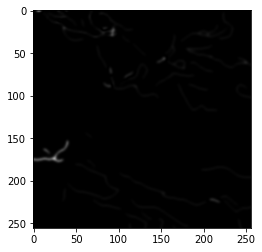

In [9]:
### Pixel-level metrics, soft IoU
ratio, U, I = iou(smooth_mask(image_1), smooth_mask(image_2), soft=True)
plt.imshow(U-I, cmap='gray')
print(np.sum(I)/np.sum(U))

### Create overlay results

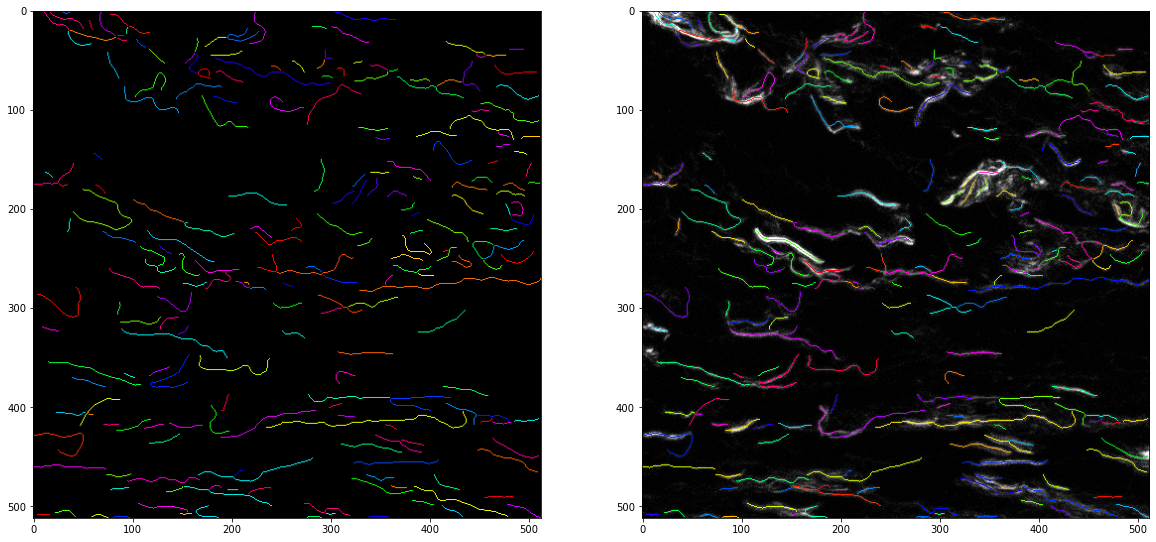

In [10]:
im_arr = io.imread('examples/example_image.tif')
## instance masks
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
centerline_res = CenterLine(centerline_image=centerline.centerline_image, associate_image=im_arr)
canvas = np.ones((centerline_res.image_size[0], centerline_res.image_size[1], 3), np.uint8) * 0
line_dict = centerline_res.line_dict
for k, v in line_dict.items():
    points = v.points
    image = np.zeros((512, 512), np.uint8)
    image = centerline_res.draw_line(points, image)
    (r, g, b) = colorsys.hsv_to_rgb(np.random.uniform(0, 1), 1.0, 1.0)
    R, G, B = int(255 * r), int(255 * g), int(255 * b)
    canvas[np.where(image>0)] = np.array([R, G, B])
ax[0].imshow(canvas)

### overlay
canvas = img_as_ubyte(np.repeat(im_arr[:, :, np.newaxis], 3, axis=2))
line_dict = centerline_res.line_dict
for k, v in line_dict.items():
    points = v.points
    image = np.zeros((512, 512), np.uint8)
    image = centerline_res.draw_line(points, image)
    (r, g, b) = colorsys.hsv_to_rgb(np.random.uniform(0, 1), 1.0, 1.0)
    R, G, B = int(255 * r), int(255 * g), int(255 * b)
    canvas[np.where(image>0)] = np.array([R, G, B])
ax[1].imshow(canvas)
plt.show()

### Print individual fiber results

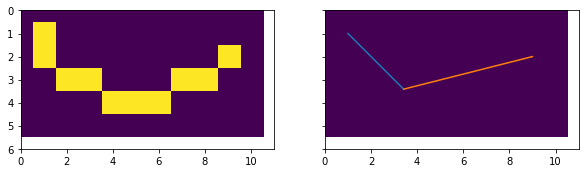

Length: 10.00, Waviness: 0.7504 



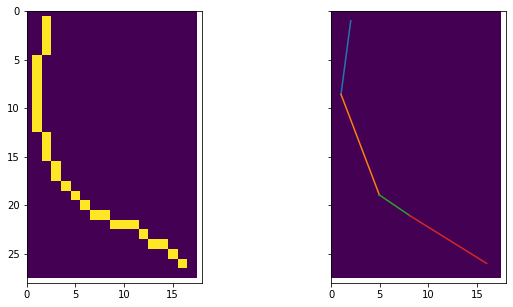

Length: 30.00, Waviness: 0.4573 



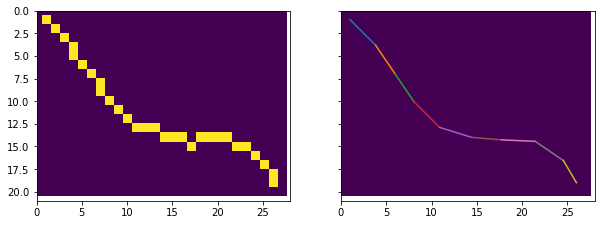

Length: 29.00, Waviness: 0.4075 



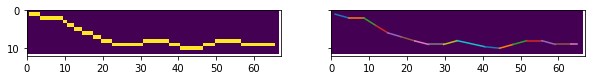

Length: 65.00, Waviness: 0.2931 



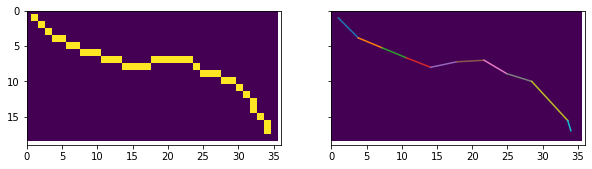

Length: 36.00, Waviness: 0.3866 



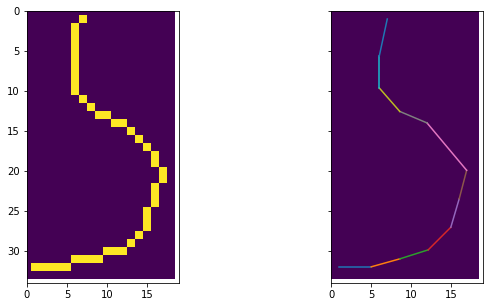

Length: 43.00, Waviness: 0.4306 



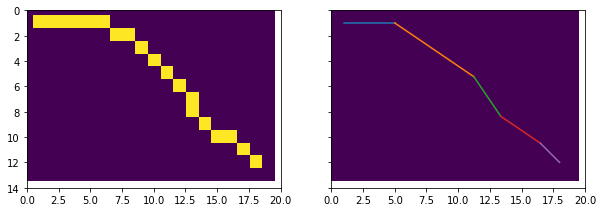

Length: 19.00, Waviness: 0.3313 



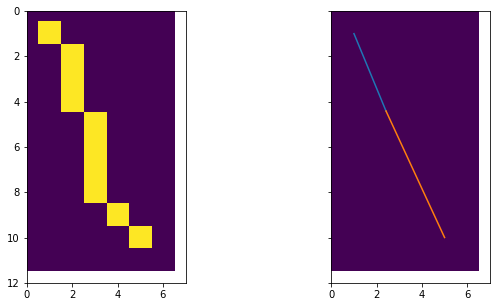

Length: 10.00, Waviness: 0.2943 



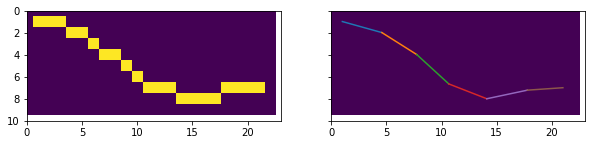

Length: 21.00, Waviness: 0.3581 



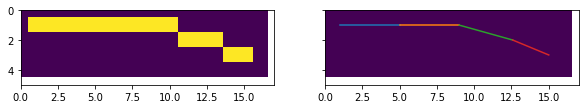

Length: 15.00, Waviness: 0.1982 



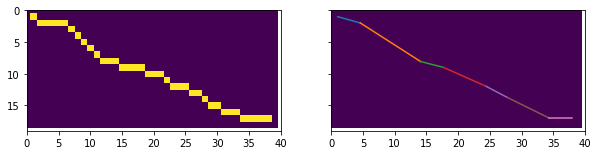

Length: 38.00, Waviness: 0.3490 



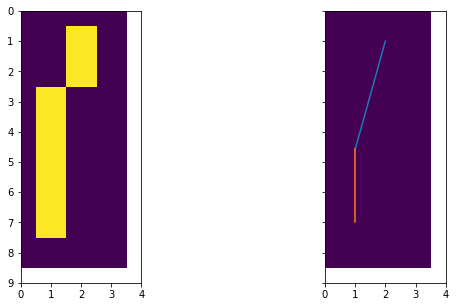

Length: 7.00, Waviness: 0.2038 



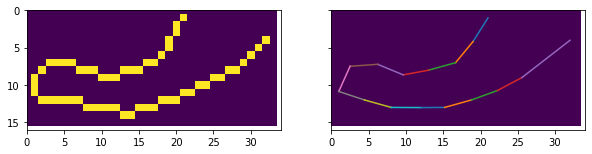

Length: 56.00, Waviness: 0.6314 



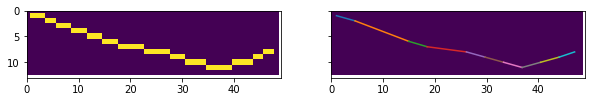

Length: 47.00, Waviness: 0.3484 



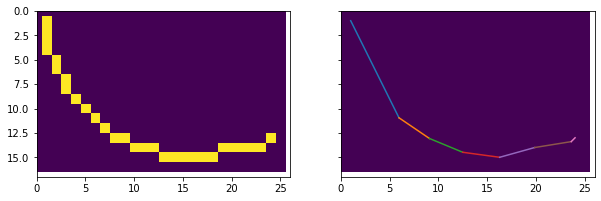

Length: 29.00, Waviness: 0.3707 



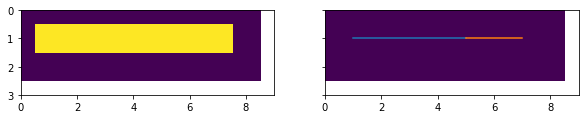

Length: 7.00, Waviness: 0.0000 



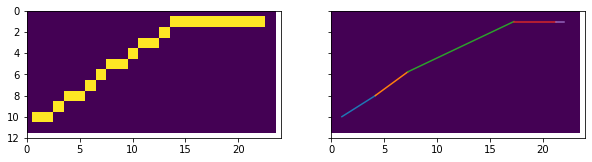

Length: 22.00, Waviness: 0.2947 



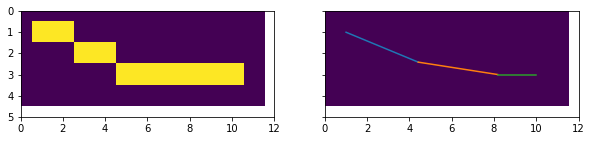

Length: 10.00, Waviness: 0.2588 



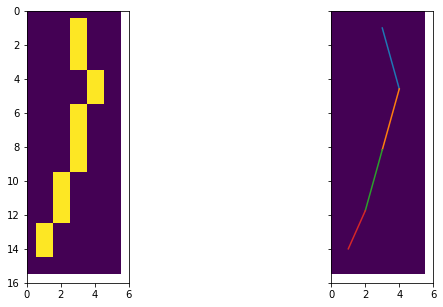

Length: 14.00, Waviness: 0.3841 



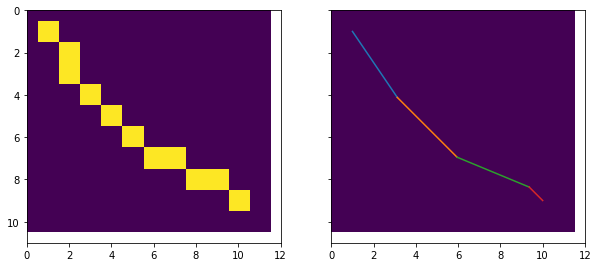

Length: 11.00, Waviness: 0.2715 



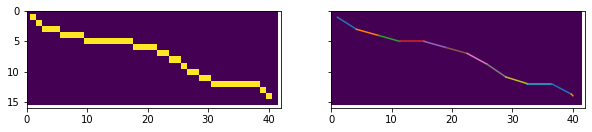

Length: 40.00, Waviness: 0.3130 



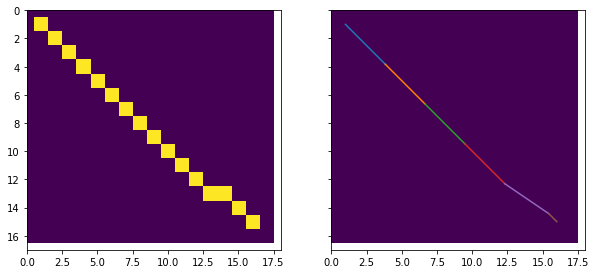

Length: 16.00, Waviness: 0.0714 



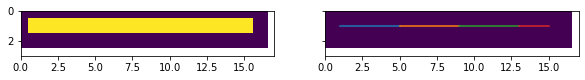

Length: 15.00, Waviness: 0.0000 



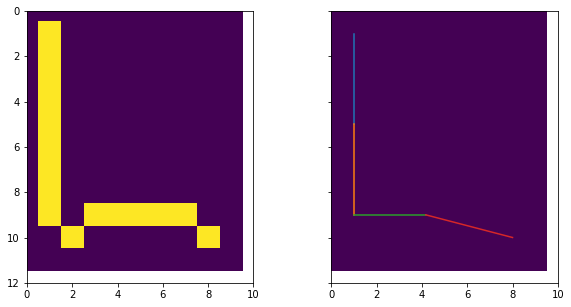

Length: 16.00, Waviness: 0.8003 



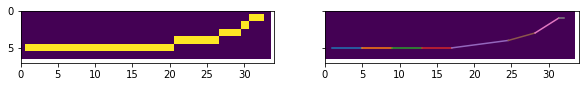

Length: 32.00, Waviness: 0.1685 



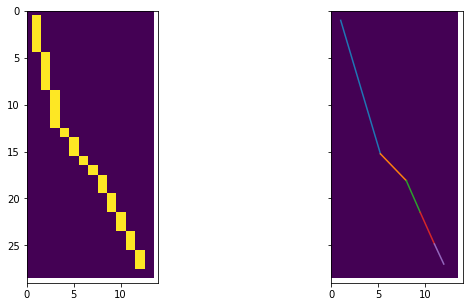

Length: 27.00, Waviness: 0.3355 



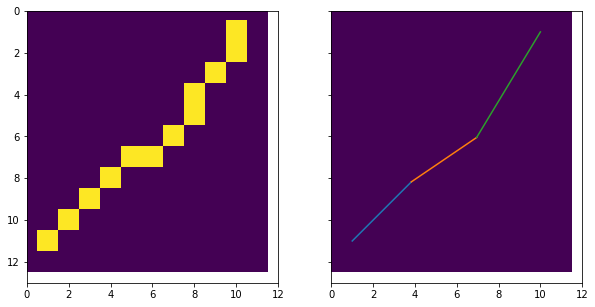

Length: 12.00, Waviness: 0.2671 



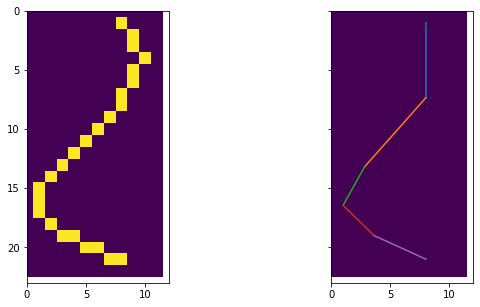

Length: 24.00, Waviness: 0.7154 



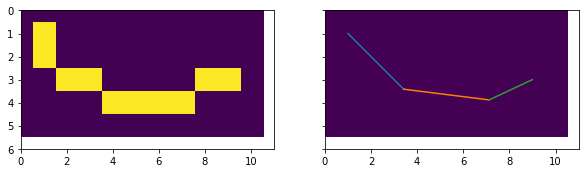

Length: 10.00, Waviness: 0.6248 



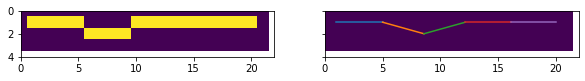

Length: 20.00, Waviness: 0.2488 



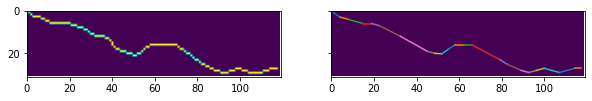

Length: 118.00, Waviness: 0.4036 



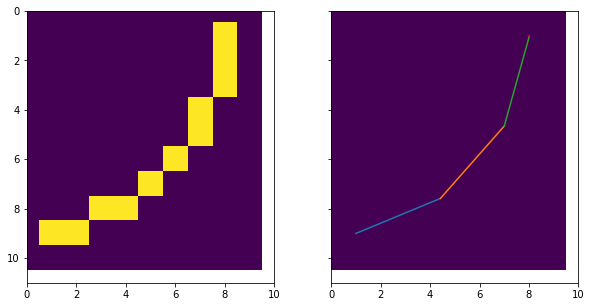

Length: 11.00, Waviness: 0.3783 



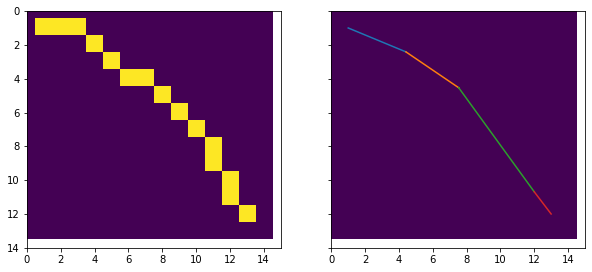

Length: 15.00, Waviness: 0.3129 



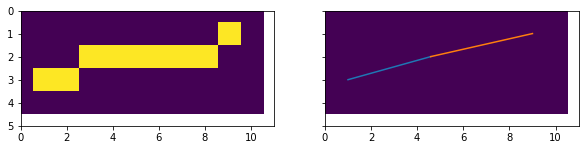

Length: 9.00, Waviness: 0.2578 



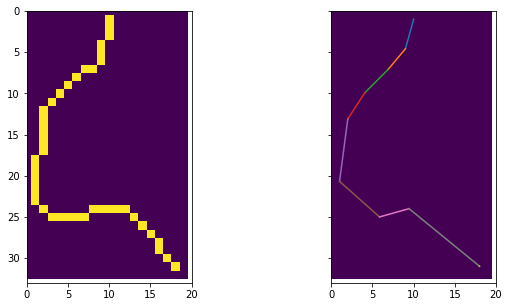

Length: 42.00, Waviness: 0.6321 



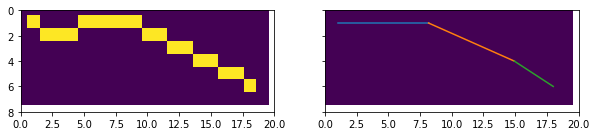

Length: 18.00, Waviness: 0.4323 



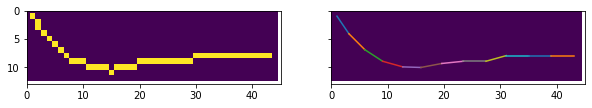

Length: 44.00, Waviness: 0.2741 



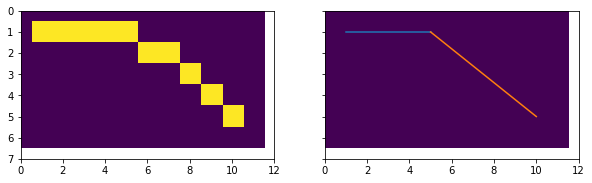

Length: 10.00, Waviness: 0.2943 



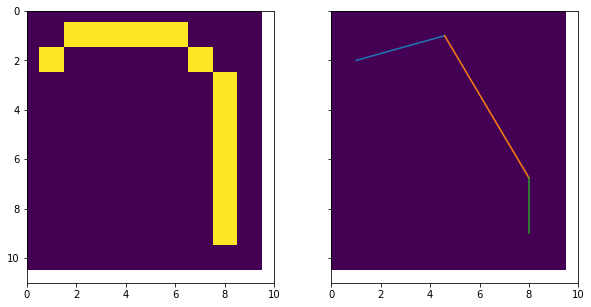

Length: 14.00, Waviness: 0.8348 



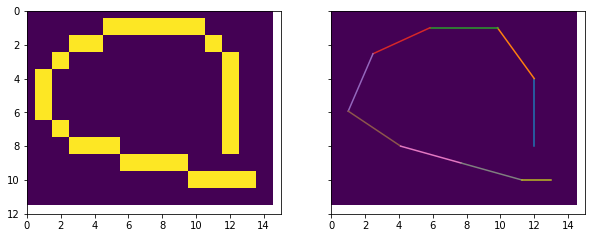

Length: 31.00, Waviness: 0.6717 



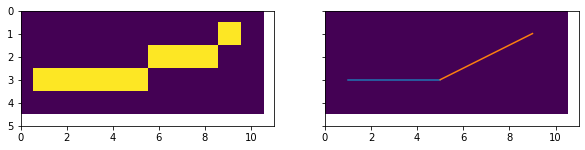

Length: 9.00, Waviness: 0.2578 



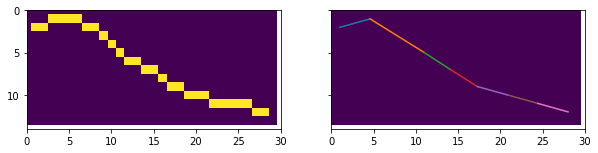

Length: 28.00, Waviness: 0.3740 



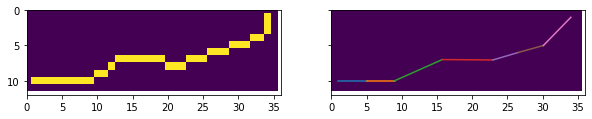

Length: 36.00, Waviness: 0.4240 



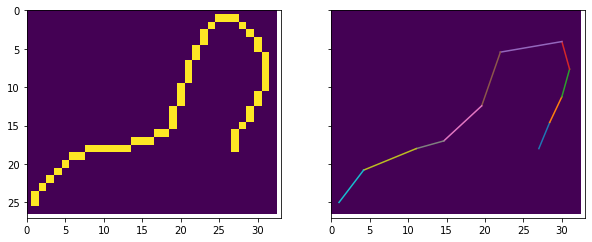

Length: 53.00, Waviness: 0.7617 



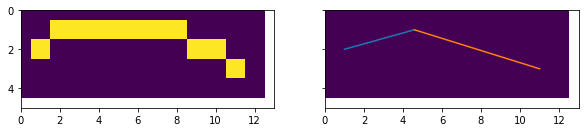

Length: 11.00, Waviness: 0.4006 



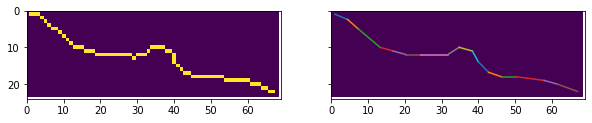

Length: 69.00, Waviness: 0.4004 



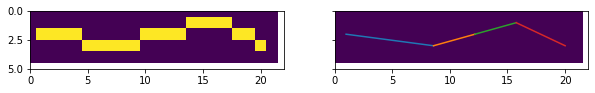

Length: 20.00, Waviness: 0.4280 



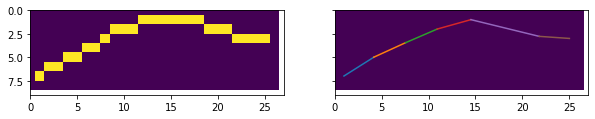

Length: 25.00, Waviness: 0.3714 



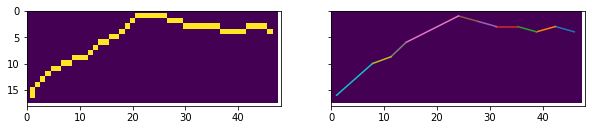

Length: 47.00, Waviness: 0.3815 



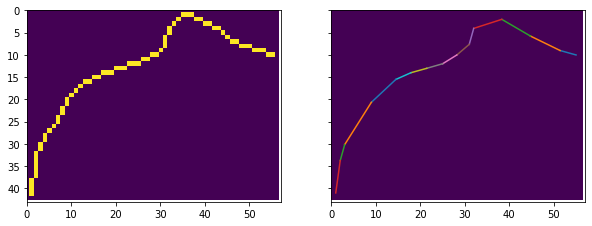

Length: 71.00, Waviness: 0.4953 



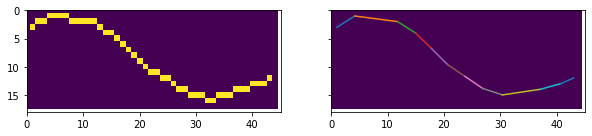

Length: 43.00, Waviness: 0.3732 



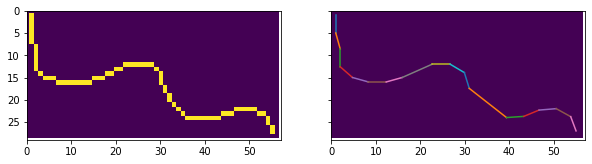

Length: 72.00, Waviness: 0.4754 



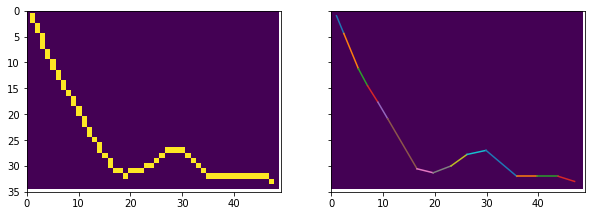

Length: 61.00, Waviness: 0.4501 



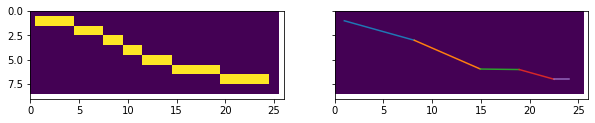

Length: 24.00, Waviness: 0.2858 



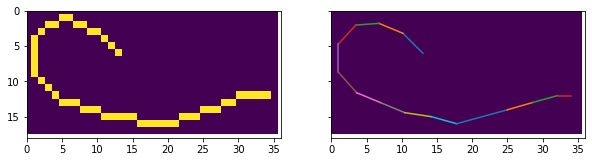

Length: 51.00, Waviness: 0.4960 



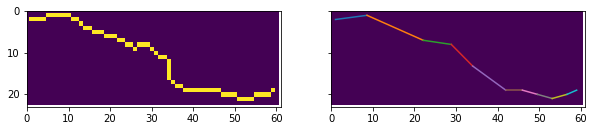

Length: 63.00, Waviness: 0.5155 



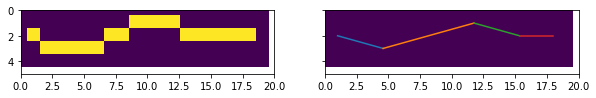

Length: 18.00, Waviness: 0.3992 



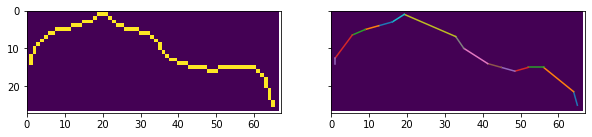

Length: 74.00, Waviness: 0.4723 



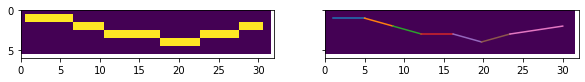

Length: 30.00, Waviness: 0.2925 



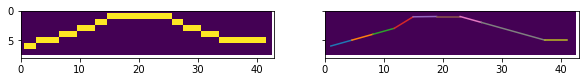

Length: 41.00, Waviness: 0.2843 



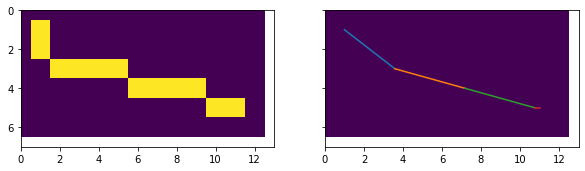

Length: 12.00, Waviness: 0.4224 



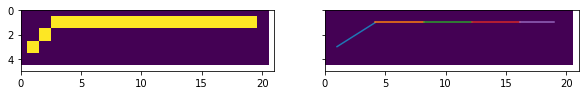

Length: 19.00, Waviness: 0.0859 



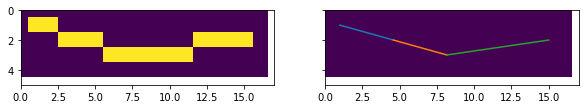

Length: 15.00, Waviness: 0.3356 



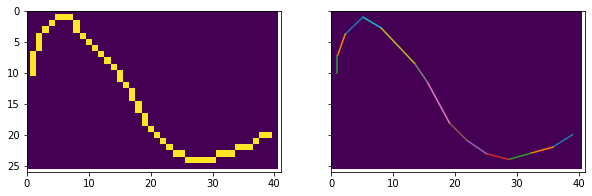

Length: 49.00, Waviness: 0.4552 



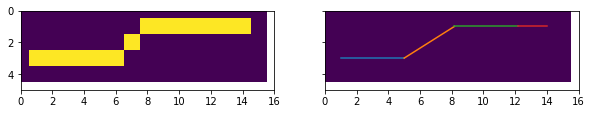

Length: 14.00, Waviness: 0.2453 



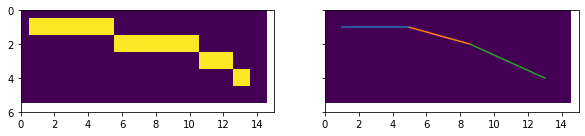

Length: 13.00, Waviness: 0.2829 



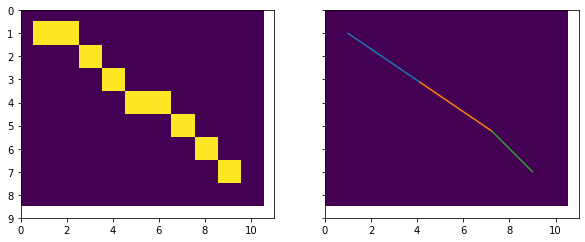

Length: 9.00, Waviness: 0.2164 



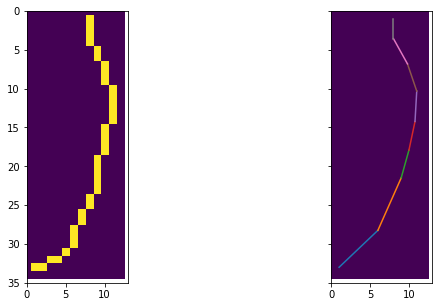

Length: 35.00, Waviness: 0.3644 



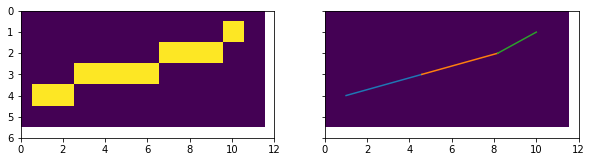

Length: 10.00, Waviness: 0.3280 



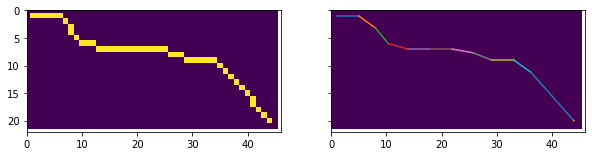

Length: 46.00, Waviness: 0.3013 



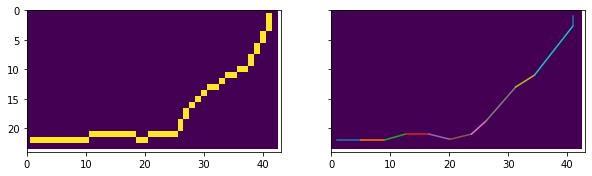

Length: 48.00, Waviness: 0.3870 



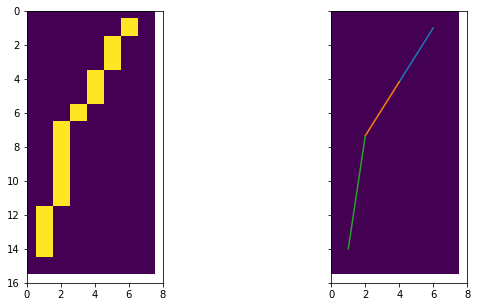

Length: 14.00, Waviness: 0.3193 



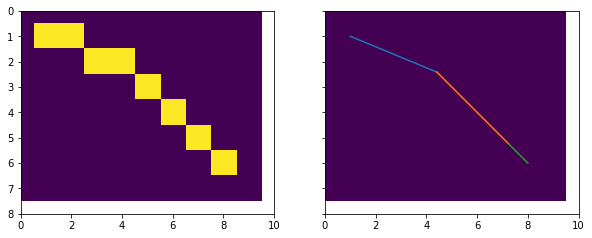

Length: 8.00, Waviness: 0.1768 



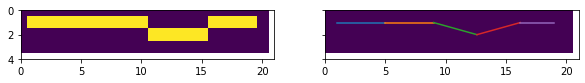

Length: 19.00, Waviness: 0.2576 



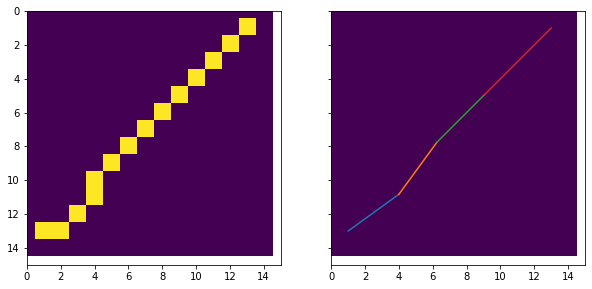

Length: 14.00, Waviness: 0.1582 



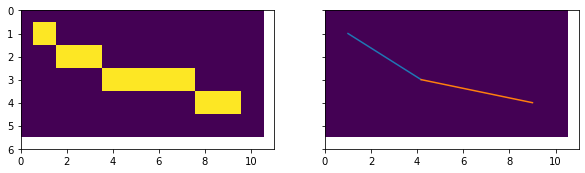

Length: 9.00, Waviness: 0.2935 



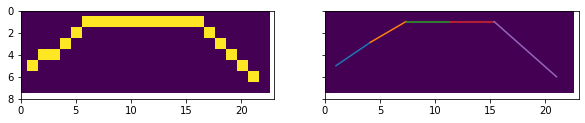

Length: 21.00, Waviness: 0.2819 



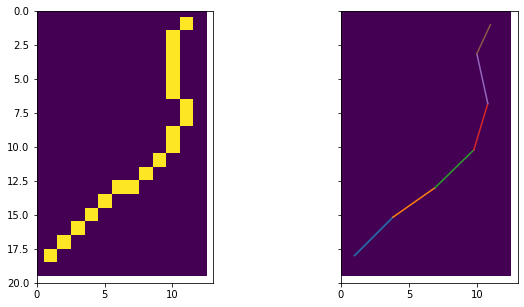

Length: 19.00, Waviness: 0.3943 



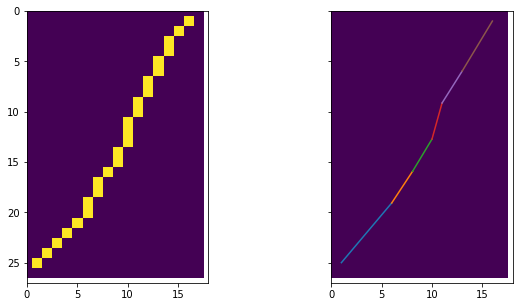

Length: 25.00, Waviness: 0.3115 



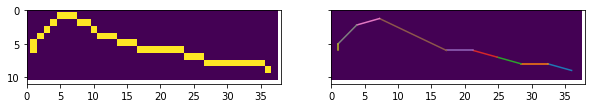

Length: 37.00, Waviness: 0.3849 



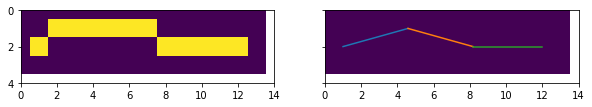

Length: 12.00, Waviness: 0.3250 



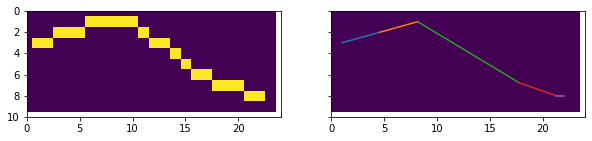

Length: 22.00, Waviness: 0.4393 



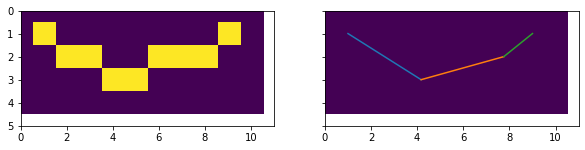

Length: 9.00, Waviness: 0.5645 



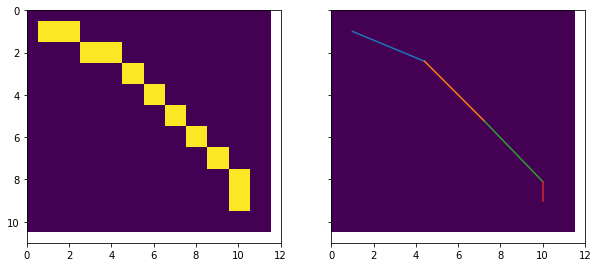

Length: 11.00, Waviness: 0.1745 



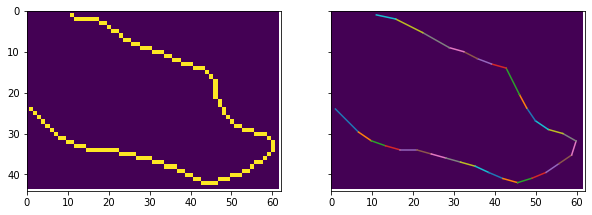

Length: 117.00, Waviness: 0.4341 



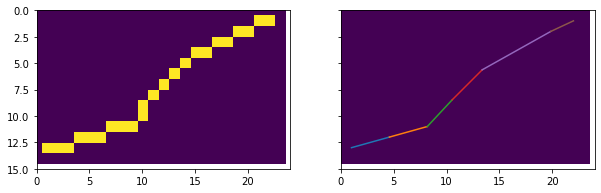

Length: 23.00, Waviness: 0.3911 



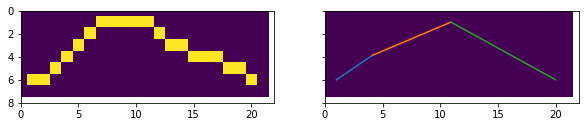

Length: 20.00, Waviness: 0.5873 



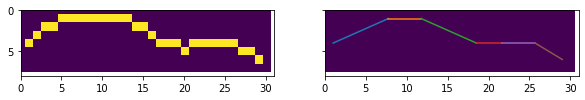

Length: 29.00, Waviness: 0.4683 



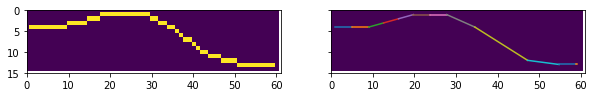

Length: 59.00, Waviness: 0.2434 



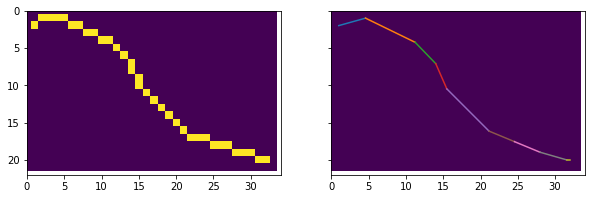

Length: 34.00, Waviness: 0.3445 



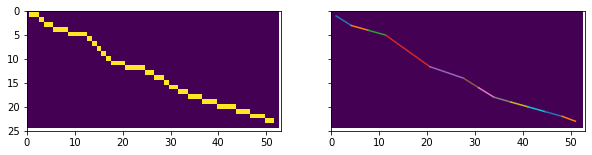

Length: 51.00, Waviness: 0.3415 



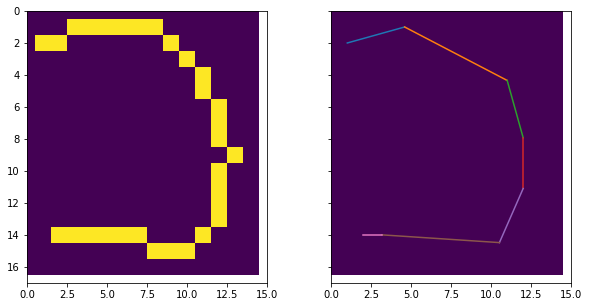

Length: 30.00, Waviness: 0.7351 



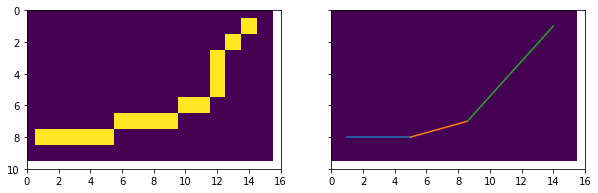

Length: 16.00, Waviness: 0.4610 



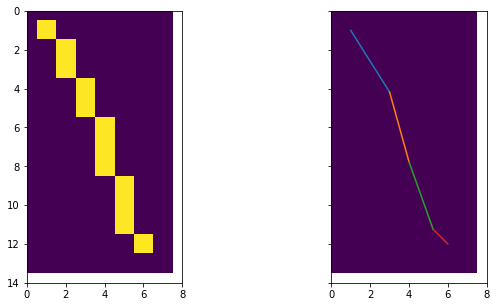

Length: 12.00, Waviness: 0.3463 



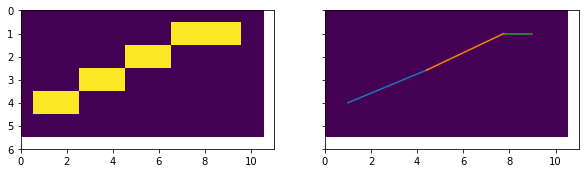

Length: 9.00, Waviness: 0.3378 



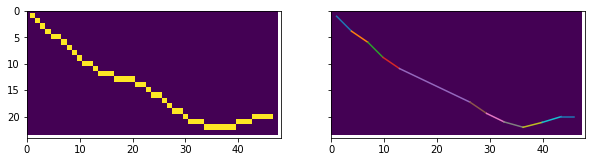

Length: 46.00, Waviness: 0.3135 



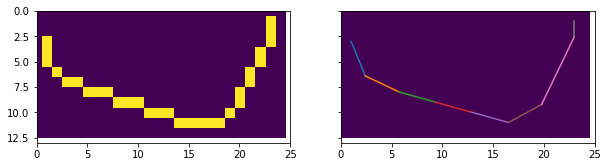

Length: 30.00, Waviness: 0.5061 



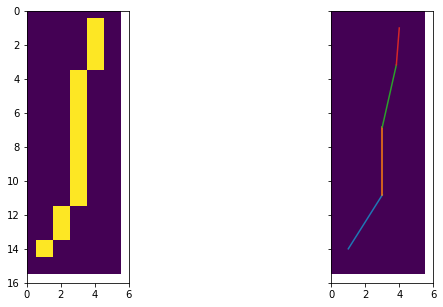

Length: 14.00, Waviness: 0.2458 



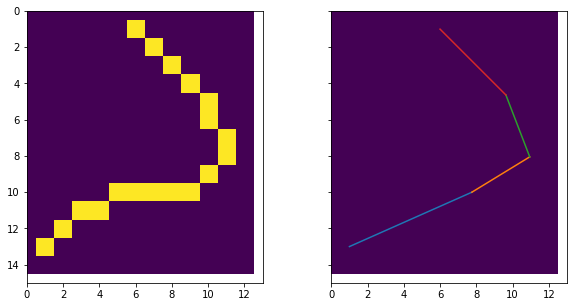

Length: 18.00, Waviness: 0.7608 



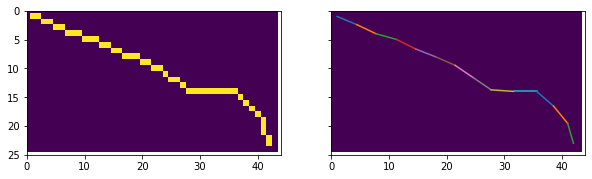

Length: 45.00, Waviness: 0.3329 



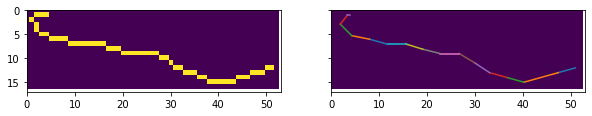

Length: 55.00, Waviness: 0.5665 



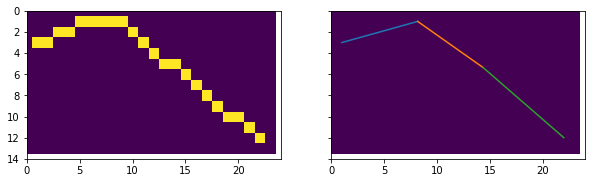

Length: 22.00, Waviness: 0.4795 



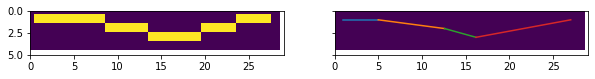

Length: 27.00, Waviness: 0.2601 



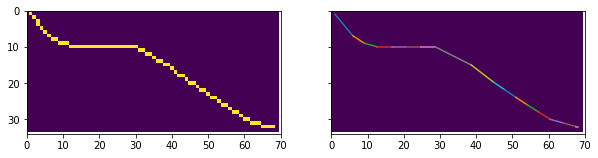

Length: 69.00, Waviness: 0.2592 



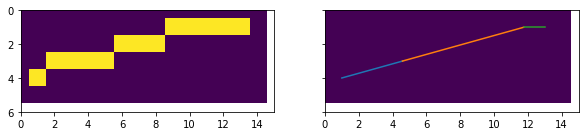

Length: 13.00, Waviness: 0.3005 



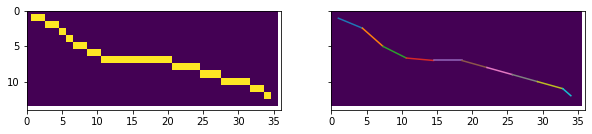

Length: 34.00, Waviness: 0.2947 



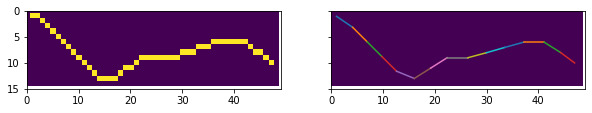

Length: 47.00, Waviness: 0.3263 



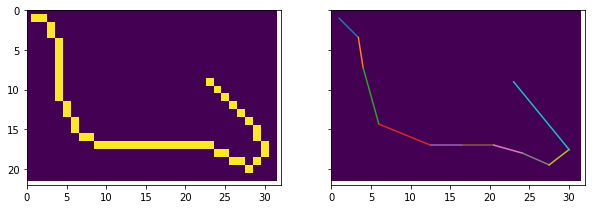

Length: 49.00, Waviness: 0.6432 



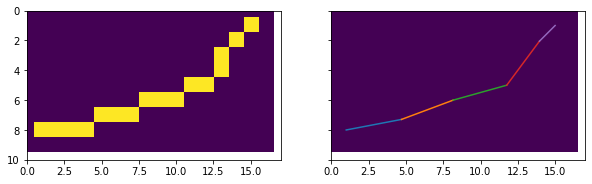

Length: 16.00, Waviness: 0.4119 



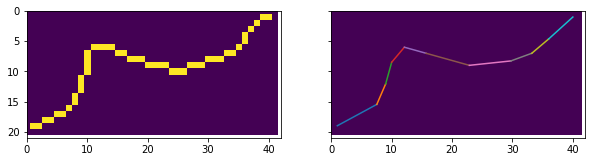

Length: 47.00, Waviness: 0.5958 



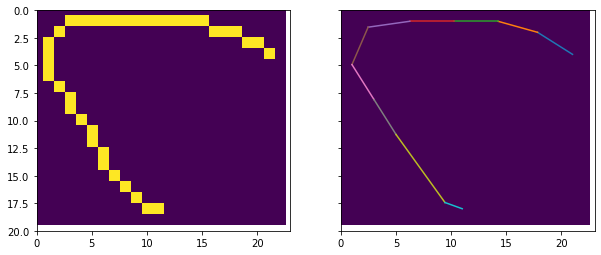

Length: 37.00, Waviness: 0.4557 



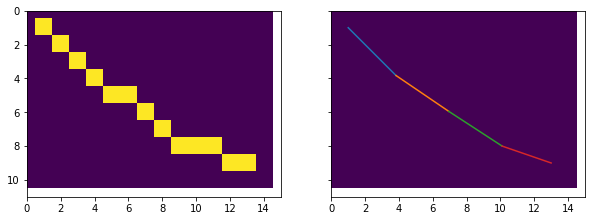

Length: 13.00, Waviness: 0.2606 



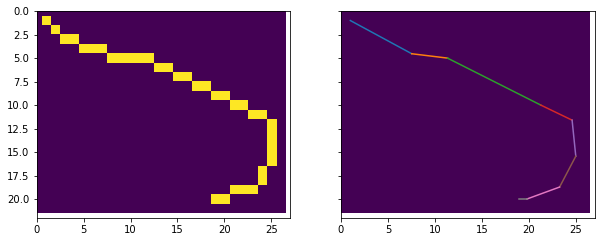

Length: 36.00, Waviness: 0.5539 



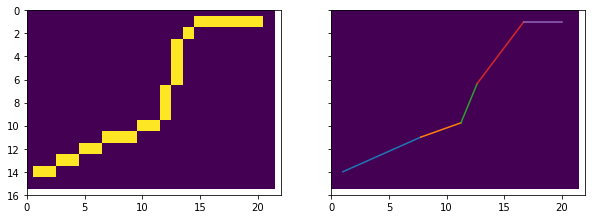

Length: 25.00, Waviness: 0.6280 



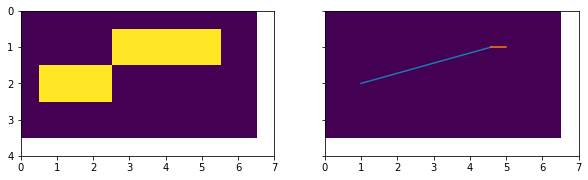

Length: 5.00, Waviness: 0.2578 



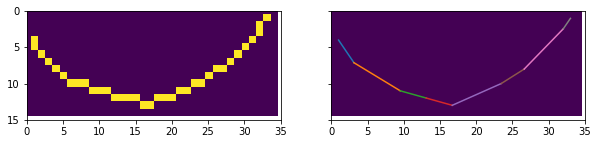

Length: 35.00, Waviness: 0.3851 



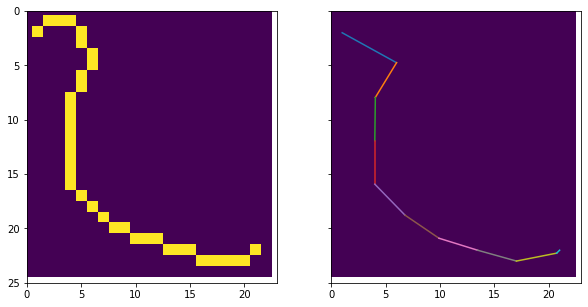

Length: 36.00, Waviness: 0.4926 



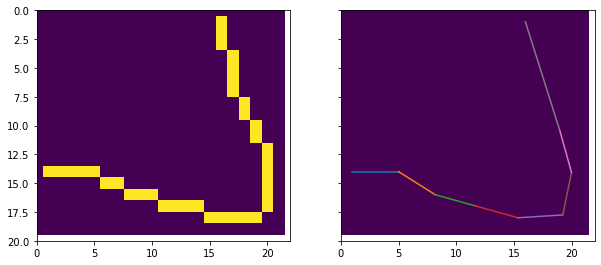

Length: 36.00, Waviness: 0.5449 



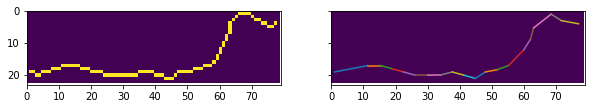

Length: 84.00, Waviness: 0.4779 



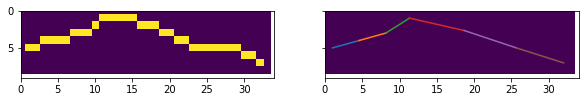

Length: 32.00, Waviness: 0.4121 



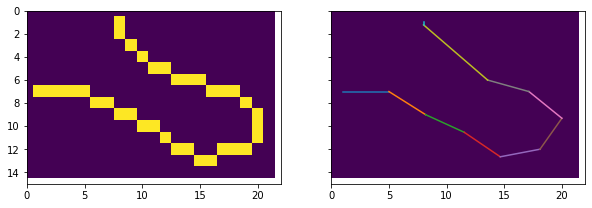

Length: 35.00, Waviness: 0.6969 



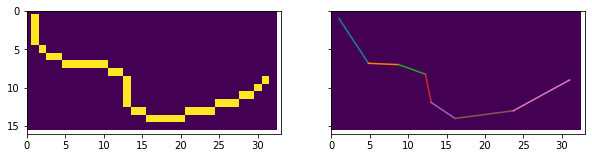

Length: 37.00, Waviness: 0.6317 



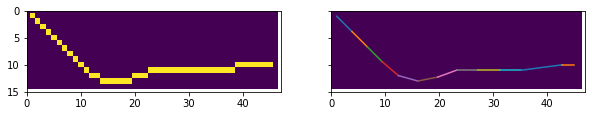

Length: 45.00, Waviness: 0.1886 



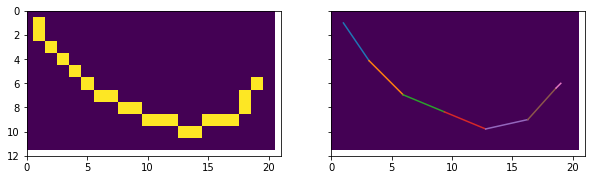

Length: 21.00, Waviness: 0.4973 



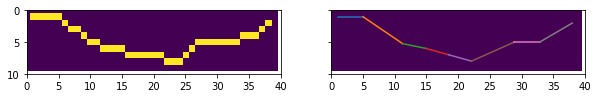

Length: 38.00, Waviness: 0.3856 



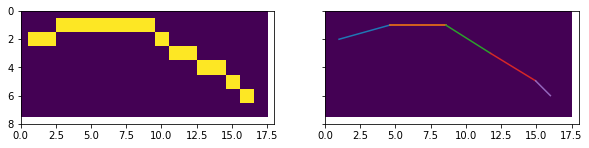

Length: 16.00, Waviness: 0.3190 



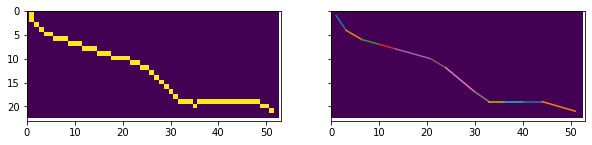

Length: 52.00, Waviness: 0.3615 



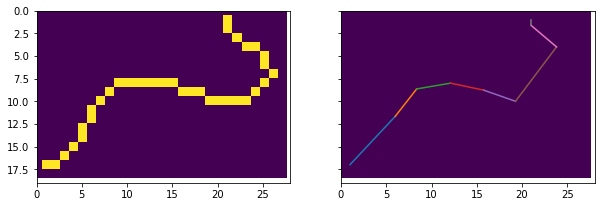

Length: 35.00, Waviness: 0.8350 



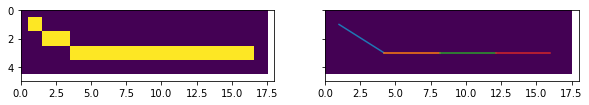

Length: 16.00, Waviness: 0.1200 



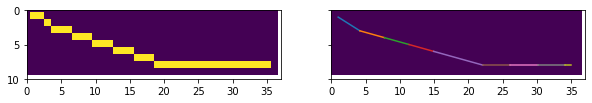

Length: 35.00, Waviness: 0.2136 



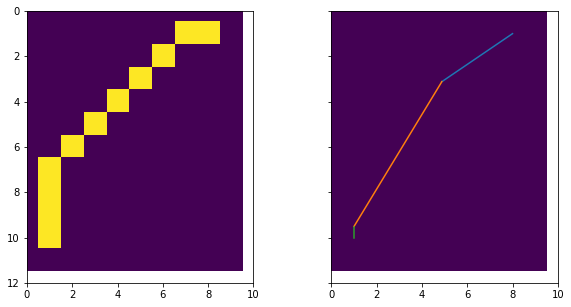

Length: 11.00, Waviness: 0.3580 



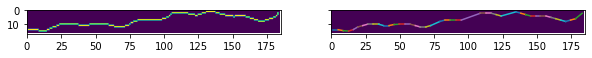

Length: 184.00, Waviness: 0.2889 



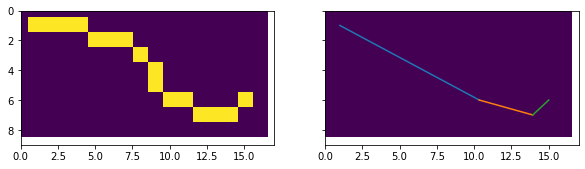

Length: 16.00, Waviness: 0.5693 



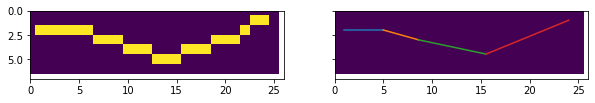

Length: 24.00, Waviness: 0.4386 



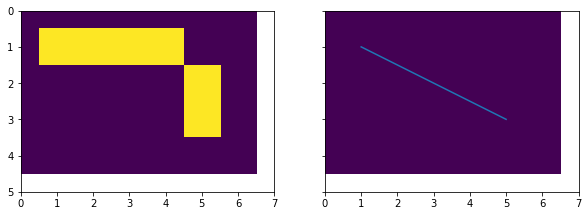

Length: 6.00, Waviness: 0.0000 



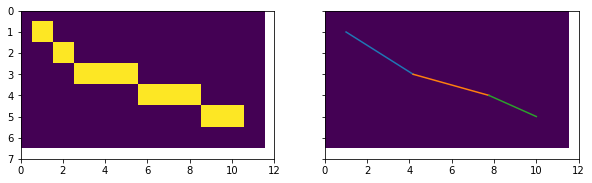

Length: 10.00, Waviness: 0.3380 



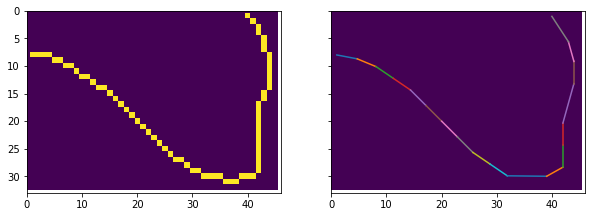

Length: 70.00, Waviness: 0.3369 



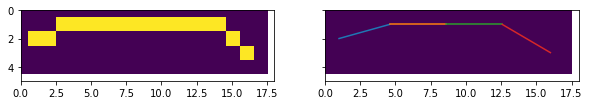

Length: 16.00, Waviness: 0.1885 



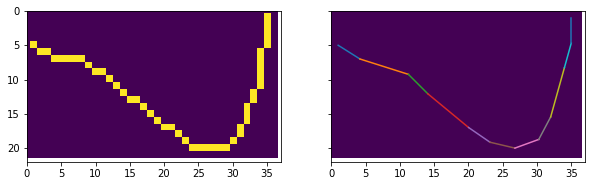

Length: 48.00, Waviness: 0.3945 



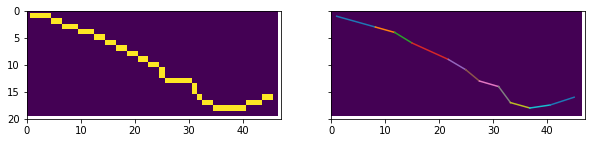

Length: 47.00, Waviness: 0.4619 



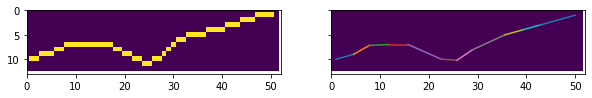

Length: 50.00, Waviness: 0.3940 



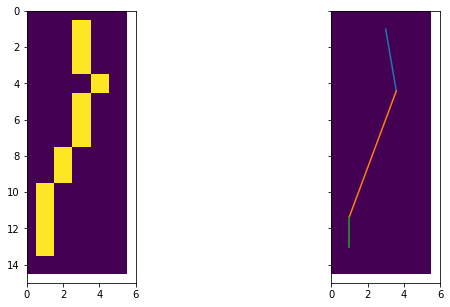

Length: 13.00, Waviness: 0.4434 



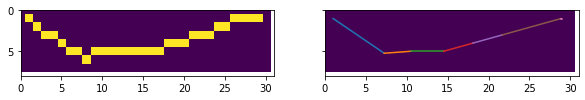

Length: 29.00, Waviness: 0.3746 



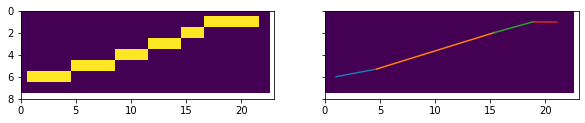

Length: 21.00, Waviness: 0.3096 



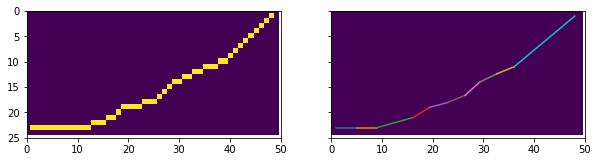

Length: 48.00, Waviness: 0.2993 



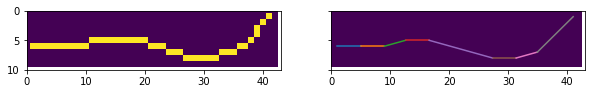

Length: 42.00, Waviness: 0.2696 



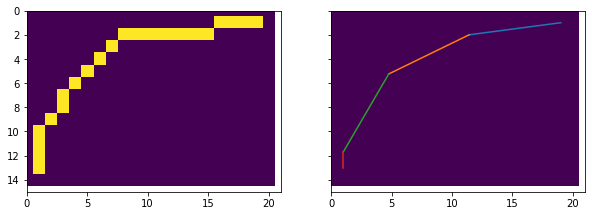

Length: 23.00, Waviness: 0.4691 



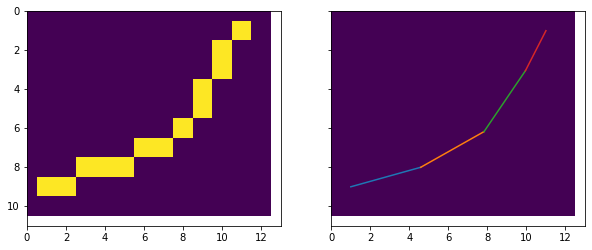

Length: 13.00, Waviness: 0.3981 



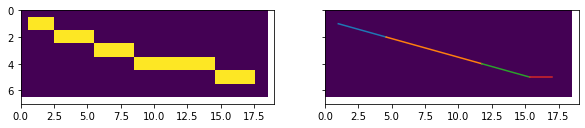

Length: 17.00, Waviness: 0.3069 



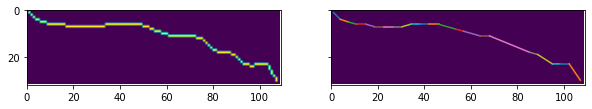

Length: 110.00, Waviness: 0.2926 



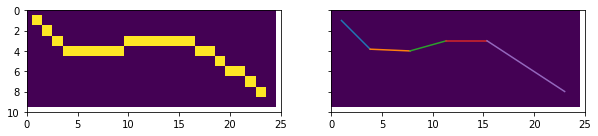

Length: 23.00, Waviness: 0.3588 



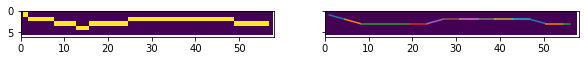

Length: 56.00, Waviness: 0.1573 



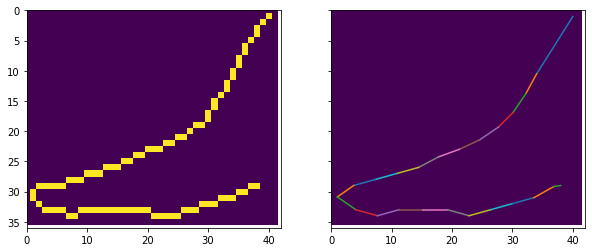

Length: 85.00, Waviness: 0.4913 



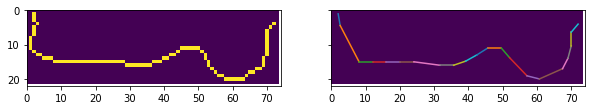

Length: 93.00, Waviness: 0.4694 



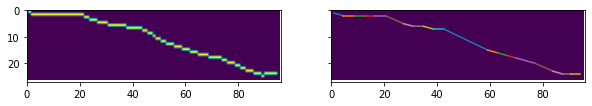

Length: 94.00, Waviness: 0.2960 



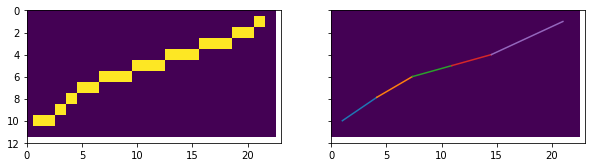

Length: 21.00, Waviness: 0.3406 



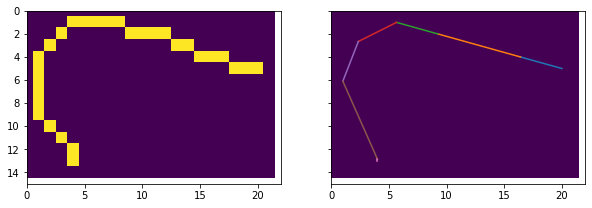

Length: 29.00, Waviness: 0.5833 



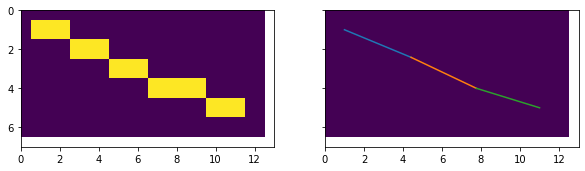

Length: 11.00, Waviness: 0.3404 



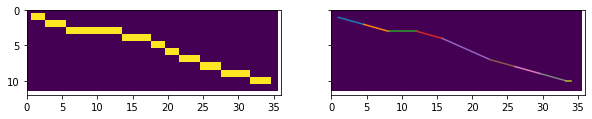

Length: 34.00, Waviness: 0.3109 



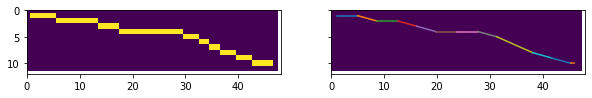

Length: 46.00, Waviness: 0.2576 



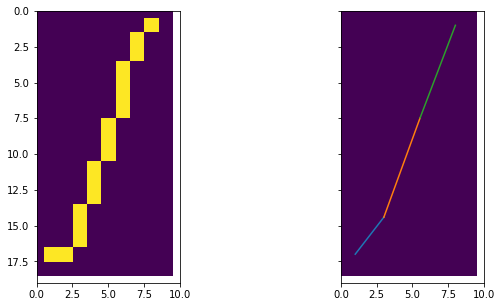

Length: 18.00, Waviness: 0.4368 



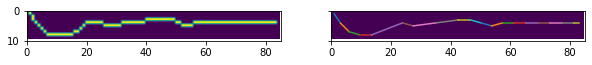

Length: 84.00, Waviness: 0.2217 



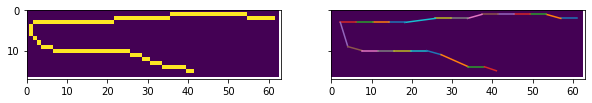

Length: 103.00, Waviness: 0.3345 



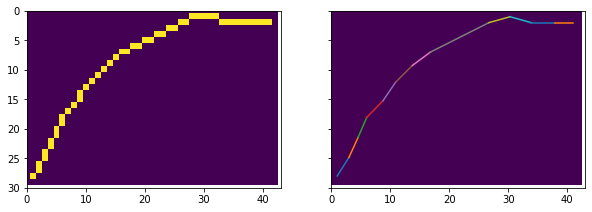

Length: 47.00, Waviness: 0.2791 



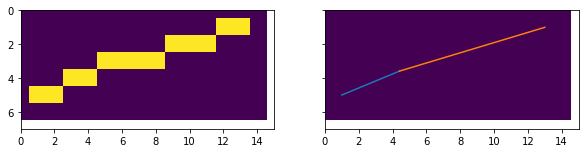

Length: 13.00, Waviness: 0.2869 



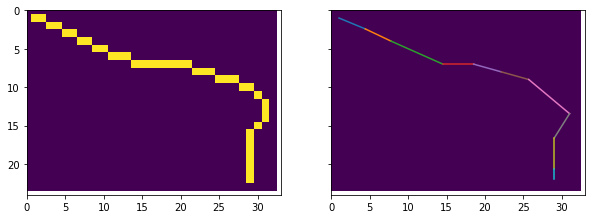

Length: 41.00, Waviness: 0.5048 



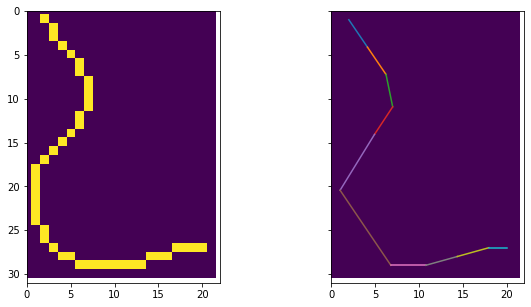

Length: 44.00, Waviness: 0.5851 



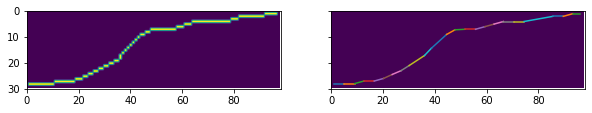

Length: 97.00, Waviness: 0.2531 



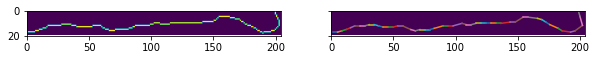

Length: 213.00, Waviness: 0.3018 



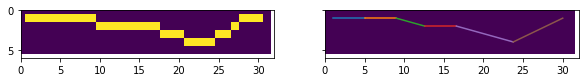

Length: 30.00, Waviness: 0.2650 



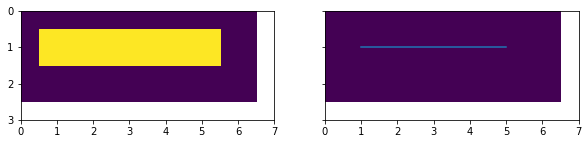

Length: 5.00, Waviness: 0.0000 



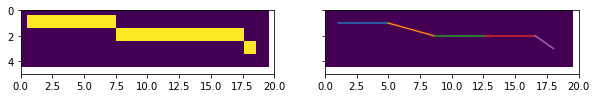

Length: 18.00, Waviness: 0.1644 



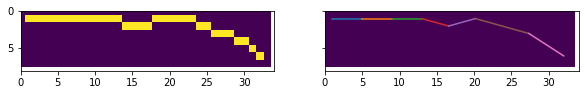

Length: 32.00, Waviness: 0.2765 



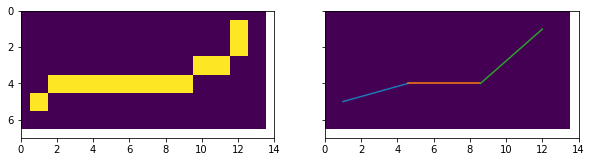

Length: 13.00, Waviness: 0.4381 



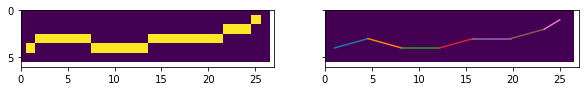

Length: 25.00, Waviness: 0.2763 



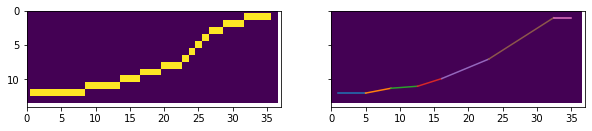

Length: 35.00, Waviness: 0.2877 



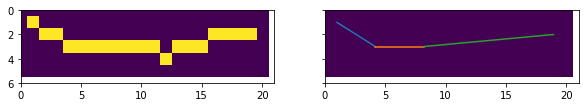

Length: 19.00, Waviness: 0.3868 



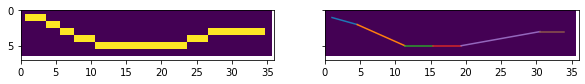

Length: 34.00, Waviness: 0.2336 



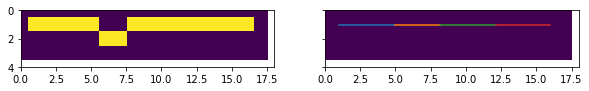

Length: 16.00, Waviness: 0.3208 



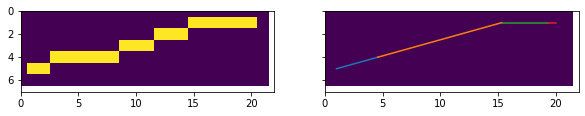

Length: 20.00, Waviness: 0.2400 



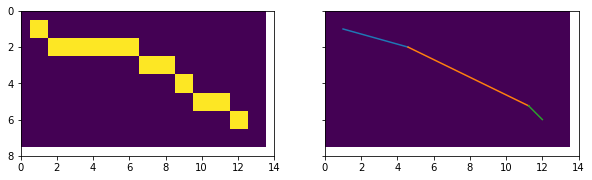

Length: 12.00, Waviness: 0.3344 



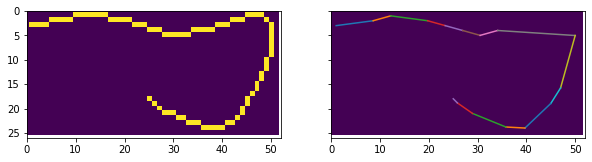

Length: 87.00, Waviness: 0.5949 



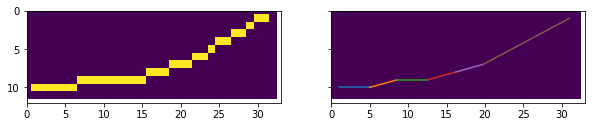

Length: 31.00, Waviness: 0.2598 



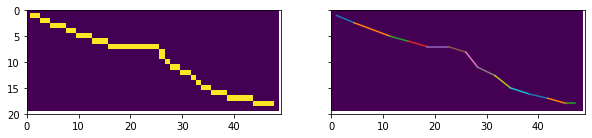

Length: 48.00, Waviness: 0.3570 



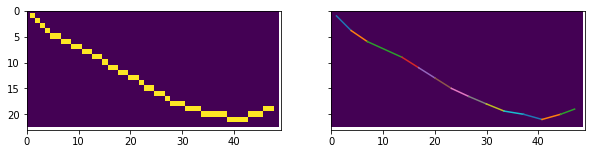

Length: 47.00, Waviness: 0.3451 



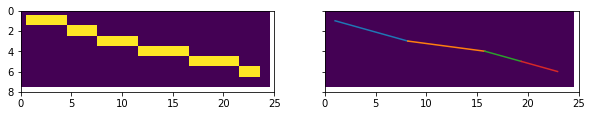

Length: 23.00, Waviness: 0.2965 



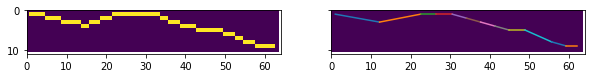

Length: 62.00, Waviness: 0.3078 



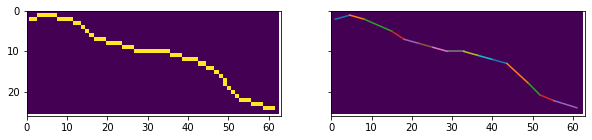

Length: 62.00, Waviness: 0.3471 



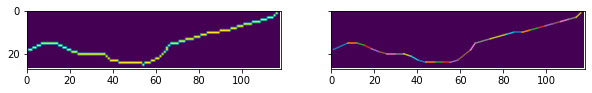

Length: 117.00, Waviness: 0.3279 



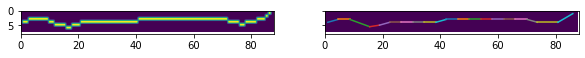

Length: 86.00, Waviness: 0.1967 



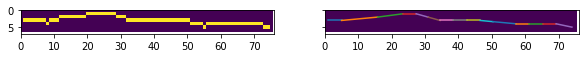

Length: 74.00, Waviness: 0.2127 



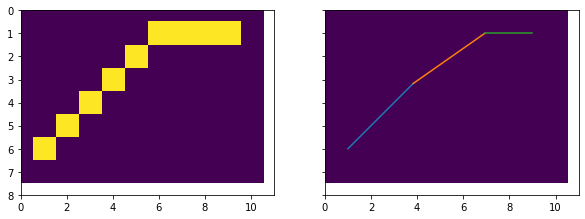

Length: 9.00, Waviness: 0.2624 



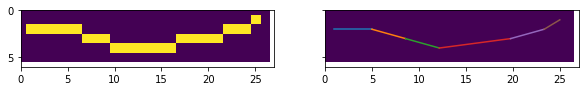

Length: 25.00, Waviness: 0.3077 



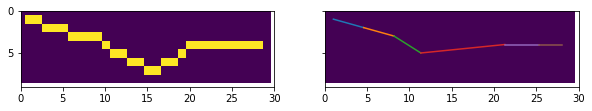

Length: 28.00, Waviness: 0.4823 



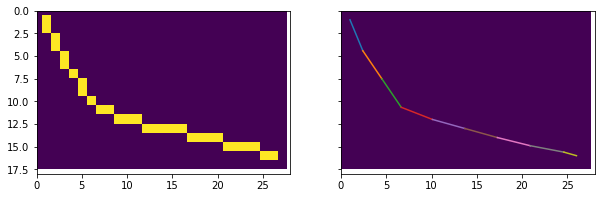

Length: 30.00, Waviness: 0.3546 



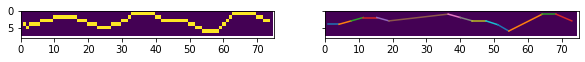

Length: 73.00, Waviness: 0.4251 



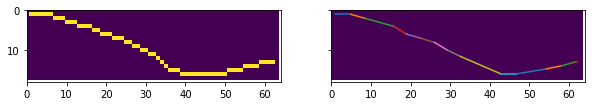

Length: 62.00, Waviness: 0.3254 



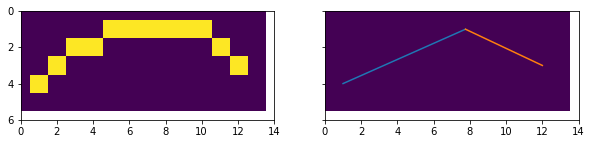

Length: 12.00, Waviness: 0.5511 



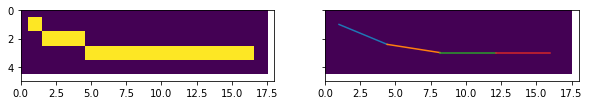

Length: 16.00, Waviness: 0.1642 



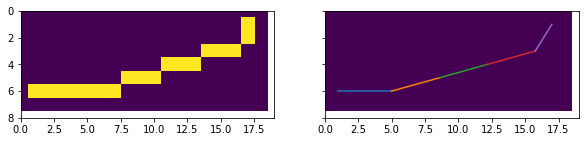

Length: 18.00, Waviness: 0.3811 



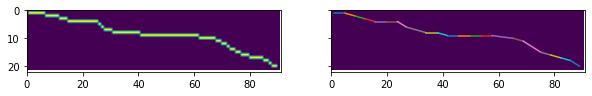

Length: 89.00, Waviness: 0.2413 



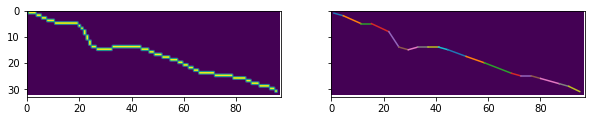

Length: 98.00, Waviness: 0.3693 



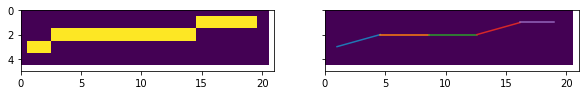

Length: 19.00, Waviness: 0.1586 



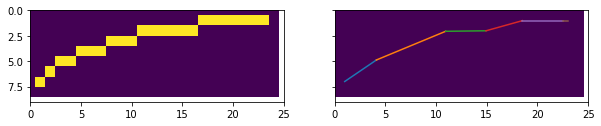

Length: 23.00, Waviness: 0.2424 



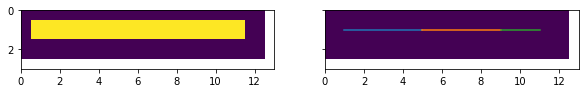

Length: 11.00, Waviness: 0.0000 



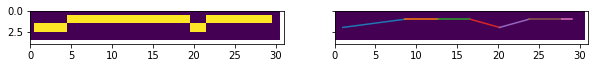

Length: 29.00, Waviness: 0.2040 



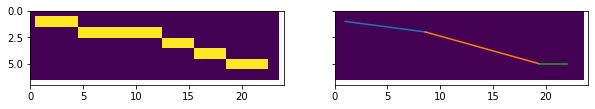

Length: 22.00, Waviness: 0.2706 



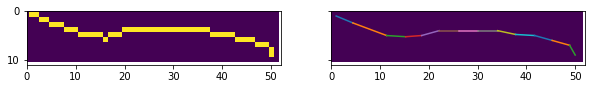

Length: 51.00, Waviness: 0.3029 



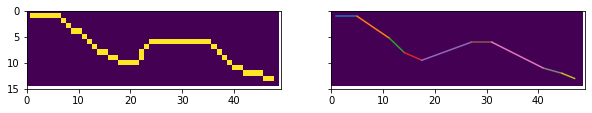

Length: 48.00, Waviness: 0.4678 



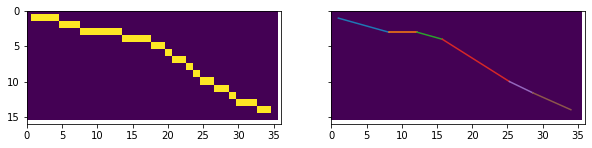

Length: 34.00, Waviness: 0.3130 



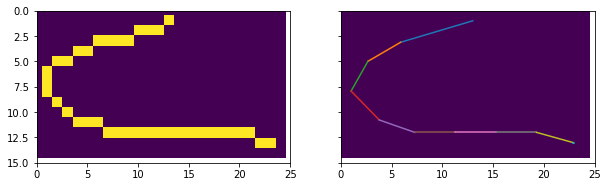

Length: 37.00, Waviness: 0.4680 



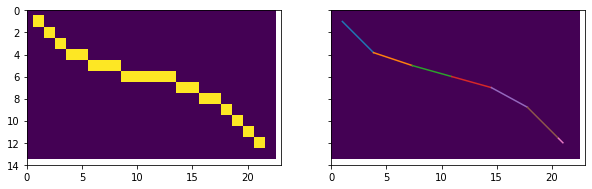

Length: 21.00, Waviness: 0.2901 



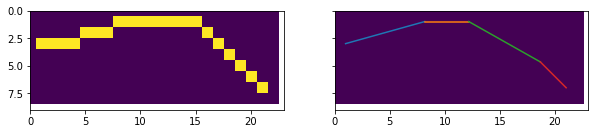

Length: 21.00, Waviness: 0.3579 



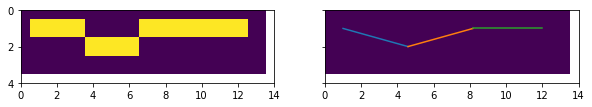

Length: 12.00, Waviness: 0.3250 



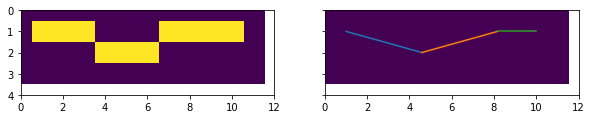

Length: 10.00, Waviness: 0.3631 



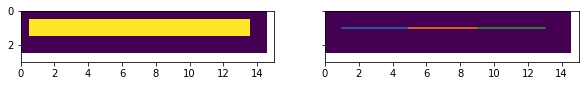

Length: 13.00, Waviness: 0.0000 



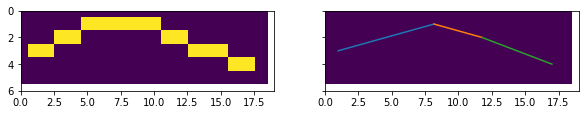

Length: 17.00, Waviness: 0.4281 



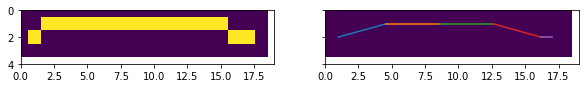

Length: 17.00, Waviness: 0.1714 



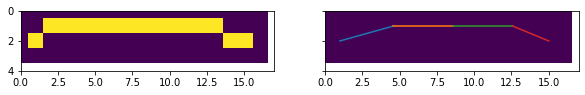

Length: 15.00, Waviness: 0.1509 



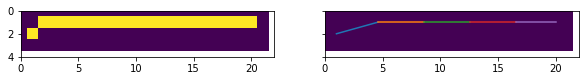

Length: 20.00, Waviness: 0.0514 



In [22]:
for id, region in enumerate(centerline.regions):
    plt.close('all')
    points_dist = lambda pt_0, pt_1 : math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
    segment_angle = lambda segment : math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) #* 180 / math.pi
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax = ax.ravel()
    region_image = np.pad( region.image, (1, 1) )
    ax[0].imshow(region_image)
    points = [centerline.Point(point[1]+1, point[0]+1) for point in region.coords]
    points = centerline.sort_points(points)
    shape_line = LineString([(point.x, point.y) for point in points])
    seg_length = 4
    num_seg = int(np.ceil(shape_line.length/seg_length))
    split_points = [int(i*seg_length) for i in range(1, num_seg)]
    splitter = MultiPoint([shape_line.interpolate(i) for i in split_points])
    if len(splitter) < 1: fragments = [shape_line]
    else: fragments = split(shape_line, splitter)
    seg_angles = []
    seg_lengths = []
    ax[1].imshow(region_image* 0)
    for fragment in fragments:
        sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
        ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]
        seg_angles, seg_lengths, waviness = centerline.single_fiber_feats(fragments)
        ax[1].plot((sx, ex), (sy, ey))
    full_length = region.area
    ax[1].set_xlim((0, region_image.shape[1]))
    ax[1].set_ylim((region_image.shape[0], 0))
    plt.show()
    print(f'Length: {full_length:.2f}, Waviness: {waviness:.4f} \n')